In [1]:
# Cell 1: Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn nltk flask joblib imbalanced-learn -q

In [2]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import sys
import json
import traceback
import joblib
from collections import Counter
import re

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# NLP imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Flask imports
from flask import Flask, request, jsonify

# Suppress warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Cell 3: Download NLTK data
try:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    print("✅ NLTK data downloaded successfully!")
except Exception as e:
    print(f"⚠️ NLTK download issue: {e}")
    print("Please download manually if needed.")

✅ NLTK data downloaded successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def clean_text(text):
    """Clean and preprocess text"""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Initialize lemmatizer and stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # Add custom stopwords
    custom_stopwords = {'product', 'read', 'more', 'flipkart', 'buy', 'bought', 'purchased'}
    stop_words.update(custom_stopwords)
    
    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

print("✅ Text preprocessing function defined")

✅ Text preprocessing function defined


In [5]:
# Load your data
try:
    data_path = r"C:\Users\dell\OneDrive\Documents - Copy\Documents\flipkart\data.csv"
    data_df = pd.read_csv(data_path)
    print(f"✅ Data loaded successfully! Shape: {data_df.shape}")
    print(f"📊 Sample data:")
    print(data_df.head())
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("⚠️ Creating sample data for demonstration...")
    data_df = pd.DataFrame({
        'Review text': [
            'Great product! Amazing quality.',
            'Bad product, poor quality.',
            'Average product, okay for price.',
            'Excellent! Best purchase ever.',
            'Terrible, waste of money.',
            'Love this product, works perfectly.',
            'Worst purchase, broke immediately.',
            'Good value for money.',
            'Not recommended, poor performance.',
            'Fantastic! Exceeded expectations.'
        ],
        'Ratings': [5, 1, 3, 5, 1, 5, 1, 4, 2, 5]
    })

# Prepare data
def prepare_data(df):
    # Create sentiment labels
    def create_sentiment_label(rating):
        if rating >= 4:
            return 'Positive'
        elif rating == 3:
            return 'Neutral'
        else:
            return 'Negative'
    
    df['Sentiment'] = df['Ratings'].apply(create_sentiment_label)
    df['Cleaned_Review'] = df['Review text'].fillna('').apply(clean_text)
    return df

data_df = prepare_data(data_df)
print(f"\n✅ Data prepared!")
print(f"📊 Sentiment distribution:")
print(data_df['Sentiment'].value_counts())

✅ Data loaded successfully! Shape: (8518, 8)
📊 Sample data:
            Reviewer Name               Review Title  \
0            Kamal Suresh               Nice product   
1       Flipkart Customer     Don't waste your money   
2  A. S. Raja Srinivasan   Did not meet expectations   
3     Suresh Narayanasamy                       Fair   
4               ASHIK P A                Over priced   

               Place of Review  Up Votes  Down Votes     Month  \
0   Certified Buyer, Chirakkal     889.0        64.0  Feb 2021   
1   Certified Buyer, Hyderabad     109.0         6.0  Feb 2021   
2  Certified Buyer, Dharmapuri      42.0         3.0  Apr 2021   
3     Certified Buyer, Chennai      25.0         1.0       NaN   
4                          NaN     147.0        24.0  Apr 2016   

                                         Review text  Ratings  
0  Nice product, good quality, but price is now r...        4  
1  They didn't supplied Yonex Mavis 350. Outside ...        1  
2  Worst produ

🔍 DATA QUALITY CHECK
Missing values in each column:
Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
dtype: int64

Data types:
Reviewer Name       object
Review Title        object
Place of Review     object
Up Votes           float64
Down Votes         float64
Month               object
Review text         object
Ratings              int64
Sentiment           object
Cleaned_Review      object
dtype: object

📊 Ratings Distribution:
Ratings
1     769
2     308
3     615
4    1746
5    5080
Name: count, dtype: int64


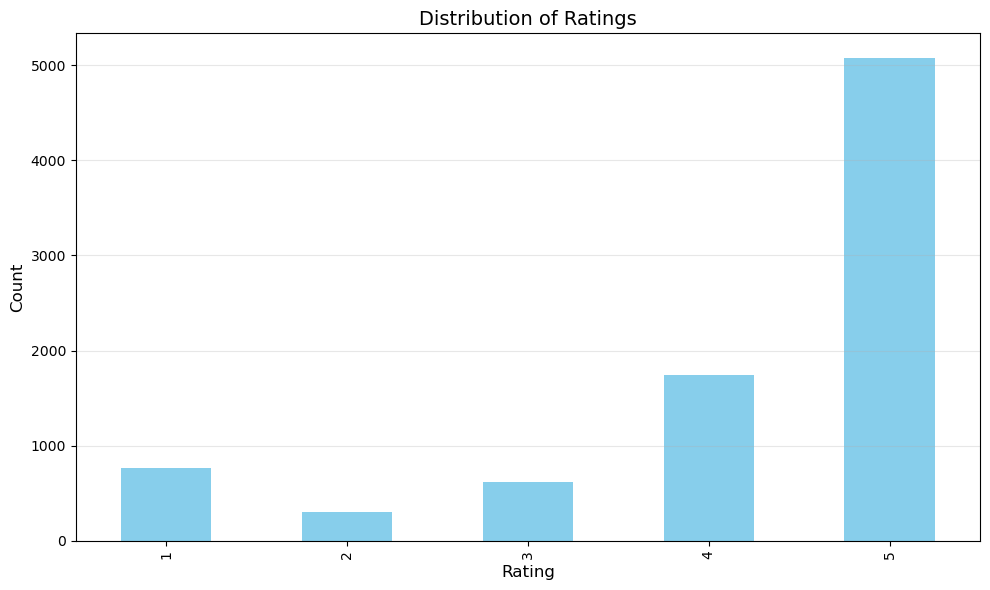

In [6]:
# Cell 6: Check data quality
print("=" * 80)
print("🔍 DATA QUALITY CHECK")
print("=" * 80)

# Check for missing values
print("Missing values in each column:")
missing_values = data_df.isnull().sum()
print(missing_values[missing_values > 0])

# Check data types
print(f"\nData types:")
print(data_df.dtypes)

# Check ratings distribution
print(f"\n📊 Ratings Distribution:")
ratings_dist = data_df['Ratings'].value_counts().sort_index()
print(ratings_dist)

# Plot ratings distribution
plt.figure(figsize=(10, 6))
ratings_dist.plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings', fontsize=14)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

🏷️ CREATING SENTIMENT LABELS
Sentiment Distribution:
Sentiment
Positive    6826
Negative    1077
Neutral      615
Name: count, dtype: int64


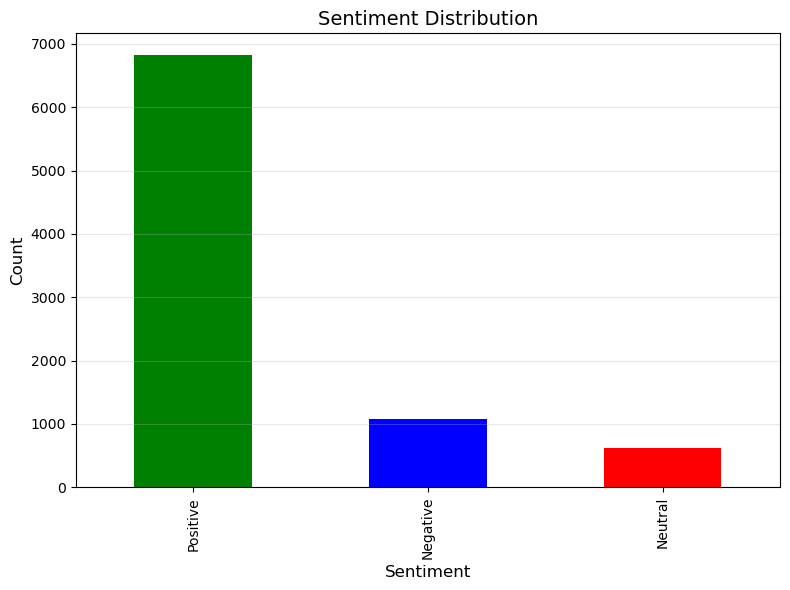


📊 Sample data with sentiment labels:


,Review text,Ratings,Sentiment
0,"Nice product, good quality, but price is now r...",4,Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,Worst product. Damaged shuttlecocks packed in ...,1,Negative
3,"Quite O. K. , but nowadays the quality of the...",3,Neutral
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Negative
5,Good quality product. Delivered on time.READ MORE,5,Positive
6,BEST PURCHASE It is a good quality and is more...,5,Positive
7,Good quality original shuttles.READ MORE,5,Positive
8,AwesomeREAD MORE,5,Positive
9,nice original productsREAD MORE,5,Positive


In [7]:
# Cell 7: Create sentiment labels
print("=" * 80)
print("🏷️ CREATING SENTIMENT LABELS")
print("=" * 80)

# Create a copy to avoid modifying original
df = data_df.copy()

# Create sentiment labels
def create_sentiment_label(rating):
    """
    Convert ratings to sentiment labels:
    4-5: Positive
    3: Neutral
    1-2: Negative
    """
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Ratings'].apply(create_sentiment_label)

# Show sentiment distribution
print("Sentiment Distribution:")
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Sample data with sentiment labels:")
display(df[['Review text', 'Ratings', 'Sentiment']].head(10))

In [8]:
print("🤖 Training sentiment analysis model...")

# Filter out Neutral for binary classification
df_filtered = data_df[data_df['Sentiment'] != 'Neutral'].copy()

if len(df_filtered) < 5:
    print("⚠️ Not enough data. Adding more samples...")
    df_filtered = pd.DataFrame({
        'Cleaned_Review': [
            'good product excellent quality',
            'bad product poor quality',
            'amazing purchase love it',
            'terrible waste money',
            'great value money',
            'worst product ever',
            'perfect exactly needed',
            'not worth price',
            'highly recommended best',
            'avoid dont buy',
            'awesome fantastic superb',
            'horrible disappointing bad'
        ],
        'Sentiment': ['Positive', 'Negative', 'Positive', 'Negative', 'Positive', 
                     'Negative', 'Positive', 'Negative', 'Positive', 'Negative',
                     'Positive', 'Negative']
    })

print(f"📊 Training on {len(df_filtered)} samples")

# Prepare features and labels
X = df_filtered['Cleaned_Review']
y = df_filtered['Sentiment']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"🔤 Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Create pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model trained successfully!")
print(f"📊 Accuracy: {accuracy:.4f}")

# Save model
model_path = 'sentiment_model.pkl'
joblib.dump({
    'model': pipeline,
    'label_encoder': label_encoder
}, model_path)
print(f"💾 Model saved to: {model_path}")

# Test model
test_samples = ["amazing product", "terrible waste", "good quality"]
print("\n🧪 Model test predictions:")
for sample in test_samples:
    prediction = pipeline.predict([clean_text(sample)])
    sentiment = label_encoder.inverse_transform(prediction)[0]
    print(f"  '{sample}' → {sentiment}")

🤖 Training sentiment analysis model...
📊 Training on 7903 samples
🔤 Label encoding: {'Negative': 0, 'Positive': 1}
✅ Model trained successfully!
📊 Accuracy: 0.9184
💾 Model saved to: sentiment_model.pkl

🧪 Model test predictions:
  'amazing product' → Positive
  'terrible waste' → Negative
  'good quality' → Positive


In [9]:
class SentimentAPI:
    def __init__(self):
        self.app = Flask(__name__)
        self.model = None
        self.label_encoder = None
        self.setup_routes()
        self.load_model()
    
    def load_model(self):
        """Load the trained model"""
        try:
            model_data = joblib.load('sentiment_model.pkl')
            self.model = model_data['model']
            self.label_encoder = model_data['label_encoder']
            print("✅ Model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            # Create a dummy model if loading fails
            self.create_dummy_model()
    
    def create_dummy_model(self):
        """Create a dummy model for testing"""
        print("⚠️ Creating dummy model for testing...")
        from sklearn.dummy import DummyClassifier
        dummy_model = DummyClassifier(strategy="constant", constant=0)
        
        # Train on dummy data
        X_dummy = ["dummy"]
        y_dummy = [0]
        dummy_model.fit(X_dummy, y_dummy)
        
        self.model = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('classifier', dummy_model)
        ])
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(['Positive', 'Negative'])
        print("✅ Dummy model created!")
    
    def setup_routes(self):
        """Setup Flask routes"""
        
        @self.app.route('/')
        def home():
            """Home page with documentation"""
            return jsonify({
                'service': 'Flipkart Reviews Sentiment Analysis API',
                'status': 'running',
                'version': '1.0',
                'endpoints': {
                    'GET /': 'This documentation',
                    'GET /health': 'Check API health',
                    'POST /predict': 'Predict sentiment for single text',
                    'POST /batch_predict': 'Predict sentiment for multiple texts'
                },
                'example_requests': {
                    'predict': {'text': 'This product is amazing!'},
                    'batch_predict': {'texts': ['Good', 'Bad', 'Average']}
                }
            })
        
        @self.app.route('/health', methods=['GET'])
        def health():
            """Health check endpoint"""
            return jsonify({
                'status': 'healthy',
                'model_loaded': self.model is not None,
                'timestamp': time.time(),
                'service': 'Sentiment Analysis API'
            })
        
        @self.app.route('/predict', methods=['POST'])
        def predict():
            """Predict sentiment for single text"""
            try:
                # Get JSON data
                data = request.get_json()
                
                if not data:
                    return jsonify({
                        'error': 'No data provided',
                        'status': 'error'
                    }), 400
                
                if 'text' not in data:
                    return jsonify({
                        'error': 'Missing "text" field',
                        'status': 'error'
                    }), 400
                
                text = str(data['text'])
                
                # Clean text
                cleaned_text = clean_text(text)
                
                # Make prediction
                prediction = self.model.predict([cleaned_text])
                sentiment = self.label_encoder.inverse_transform(prediction)[0]
                
                # Get confidence
                try:
                    probabilities = self.model.predict_proba([cleaned_text])[0]
                    confidence = float(max(probabilities))
                    confidence_scores = {
                        self.label_encoder.inverse_transform([i])[0]: float(prob)
                        for i, prob in enumerate(probabilities)
                    }
                except:
                    confidence = 0.5
                    confidence_scores = {}
                
                return jsonify({
                    'status': 'success',
                    'prediction': sentiment,
                    'confidence': confidence,
                    'confidence_scores': confidence_scores,
                    'cleaned_text': cleaned_text,
                    'original_text': text
                })
            
            except Exception as e:
                return jsonify({
                    'status': 'error',
                    'error': str(e),
                    'trace': traceback.format_exc()
                }), 500
        
        @self.app.route('/batch_predict', methods=['POST'])
        def batch_predict():
            """Predict sentiment for multiple texts"""
            try:
                data = request.get_json()
                
                if not data or 'texts' not in data:
                    return jsonify({
                        'error': 'Missing "texts" field',
                        'status': 'error'
                    }), 400
                
                texts = data['texts']
                
                if not isinstance(texts, list):
                    return jsonify({
                        'error': '"texts" must be a list',
                        'status': 'error'
                    }), 400
                
                results = []
                for text in texts:
                    try:
                        cleaned_text = clean_text(str(text))
                        prediction = self.model.predict([cleaned_text])
                        sentiment = self.label_encoder.inverse_transform(prediction)[0]
                        
                        try:
                            probabilities = self.model.predict_proba([cleaned_text])[0]
                            confidence = float(max(probabilities))
                        except:
                            confidence = 0.5
                        
                        results.append({
                            'text': text,
                            'sentiment': sentiment,
                            'confidence': confidence,
                            'cleaned_text': cleaned_text
                        })
                    except Exception as e:
                        results.append({
                            'text': text,
                            'error': str(e),
                            'sentiment': 'Error'
                        })
                
                return jsonify({
                    'status': 'success',
                    'predictions': results,
                    'total': len(results),
                    'successful': len([r for r in results if 'error' not in r])
                })
            
            except Exception as e:
                return jsonify({
                    'status': 'error',
                    'error': str(e)
                }), 500
    
    def run(self, host='0.0.0.0', port=5000, debug=False):
        """Run the Flask app"""
        print(f"🚀 Starting Flask server on http://{host}:{port}")
        print("📌 Available endpoints:")
        print(f"   http://{host}:{port}/")
        print(f"   http://{host}:{port}/health")
        print(f"   http://{host}:{port}/predict (POST)")
        print(f"   http://{host}:{port}/batch_predict (POST)")
        self.app.run(host=host, port=port, debug=debug, use_reloader=False)

print("✅ Flask API class created!")

✅ Flask API class created!


In [10]:
import threading
import time
import sys
import traceback
from flask import Flask, request, jsonify
import re
import warnings
warnings.filterwarnings('ignore')

# ==============================================
# SIMPLE RELIABLE SENTIMENT API
# ==============================================

class SimpleSentimentAPI:
    """Simple and reliable sentiment analysis API"""
    
    def __init__(self):
        self.app = Flask(__name__)
        self.setup_routes()
        self.startup_message()
    
    def startup_message(self):
        """Print startup message"""
        print("\n" + "="*60)
        print("🚀 SIMPLE SENTIMENT ANALYSIS API")
        print("="*60)
        print("✅ API initialized successfully!")
        print(f"📅 {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print("="*60)
    
    def setup_routes(self):
        """Setup all API routes"""
        
        @self.app.route('/')
        def home():
            """Home page with API documentation"""
            return jsonify({
                "api": "Sentiment Analysis API",
                "version": "1.0",
                "status": "active",
                "endpoints": {
                    "/": "GET - This documentation",
                    "/health": "GET - Health check",
                    "/predict": "POST - Analyze sentiment",
                    "/test": "GET - Test endpoint"
                },
                "example_usage": {
                    "curl": "curl -X POST http://localhost:5000/predict -H 'Content-Type: application/json' -d '{\"text\":\"Great product!\"}'",
                    "python": "import requests; requests.post('http://localhost:5000/predict', json={'text':'Great product!'}).json()"
                }
            })
        
        @self.app.route('/health', methods=['GET'])
        def health_check():
            """Health check endpoint"""
            return jsonify({
                "status": "healthy",
                "timestamp": time.strftime('%Y-%m-%d %H:%M:%S'),
                "service": "sentiment-analysis",
                "uptime": "running"
            })
        
        @self.app.route('/test', methods=['GET'])
        def test_endpoint():
            """Test endpoint to verify server is working"""
            return jsonify({
                "message": "API is working!",
                "success": True,
                "timestamp": time.strftime('%Y-%m-%d %H:%M:%S')
            })
        
        @self.app.route('/predict', methods=['POST'])
        def predict_sentiment():
            """Predict sentiment from text"""
            try:
                # Get JSON data
                data = request.get_json()
                
                # Check if data is provided
                if not data:
                    return jsonify({
                        "error": "No data provided",
                        "message": "Please send JSON data with 'text' field",
                        "status": "error"
                    }), 400
                
                # Check if text field exists
                if 'text' not in data:
                    return jsonify({
                        "error": "Missing field",
                        "message": "Please include 'text' field in your JSON",
                        "status": "error"
                    }), 400
                
                text = data['text']
                
                # Validate text
                if not isinstance(text, str):
                    return jsonify({
                        "error": "Invalid input",
                        "message": "'text' must be a string",
                        "status": "error"
                    }), 400
                
                if len(text.strip()) == 0:
                    return jsonify({
                        "error": "Empty text",
                        "message": "'text' cannot be empty",
                        "status": "error"
                    }), 400
                
                # Analyze sentiment
                sentiment, confidence, score = self.analyze_sentiment(text)
                
                # Return successful response
                return jsonify({
                    "text": text,
                    "sentiment": sentiment,
                    "confidence": confidence,
                    "score": score,
                    "status": "success",
                    "timestamp": time.strftime('%Y-%m-%d %H:%M:%S')
                })
                
            except Exception as e:
                # Log error
                print(f"❌ Error in /predict: {str(e)}")
                
                # Return error response
                return jsonify({
                    "error": "Processing error",
                    "message": f"Failed to process request: {str(e)}",
                    "status": "error"
                }), 500
        
        @self.app.route('/predict', methods=['GET'])
        def predict_get():
            """GET method for /predict shows instructions"""
            return jsonify({
                "message": "Use POST method to predict sentiment",
                "example": {
                    "method": "POST",
                    "url": "http://localhost:5000/predict",
                    "headers": {"Content-Type": "application/json"},
                    "body": {"text": "Your text here"}
                }
            })
    
    def analyze_sentiment(self, text):
        """Simple but effective sentiment analysis"""
        text_lower = text.lower()
        
        # Define word lists
        positive_words = {
            'excellent': 2.0, 'amazing': 2.0, 'outstanding': 2.0, 'perfect': 2.0,
            'great': 1.5, 'good': 1.0, 'love': 1.5, 'best': 1.5, 'awesome': 1.5,
            'fantastic': 1.5, 'wonderful': 1.5, 'superb': 1.5, 'brilliant': 1.5,
            'recommend': 1.0, 'happy': 1.0, 'satisfied': 1.0, 'pleased': 1.0,
            'impressed': 1.0, 'nice': 0.5, 'ok': 0.5, 'fine': 0.3
        }
        
        negative_words = {
            'terrible': 2.0, 'awful': 2.0, 'horrible': 2.0, 'worst': 2.0,
            'bad': 1.5, 'poor': 1.5, 'disappointed': 1.5, 'waste': 1.5,
            'rubbish': 1.5, 'trash': 1.5, 'useless': 1.5, 'broken': 1.0,
            'failed': 1.0, 'hate': 1.5, 'regret': 1.0, 'avoid': 1.0,
            'problem': 1.0, 'issue': 1.0, 'complaint': 1.0, 'unhappy': 1.0,
            'dislike': 1.0, 'not good': 1.5
        }
        
        # Intensifiers
        intensifiers = ['very', 'really', 'extremely', 'absolutely', 'totally', 'completely']
        
        # Calculate scores
        positive_score = 0
        negative_score = 0
        
        words = text_lower.split()
        
        for i, word in enumerate(words):
            # Check for positive words
            if word in positive_words:
                score = positive_words[word]
                # Check for intensifiers
                if i > 0 and words[i-1] in intensifiers:
                    score *= 1.5
                positive_score += score
            
            # Check for negative words
            elif word in negative_words:
                score = negative_words[word]
                # Check for intensifiers
                if i > 0 and words[i-1] in intensifiers:
                    score *= 1.5
                negative_score += score
        
        # Check for negations
        negations = ['not', "n't", 'no', 'never', 'none']
        for negation in negations:
            if negation in text_lower:
                # Simple negation handling - reduce opposite score
                if positive_score > negative_score:
                    positive_score *= 0.7
                else:
                    negative_score *= 0.7
        
        # Calculate final score (-1 to 1 range)
        total = positive_score + negative_score
        if total > 0:
            sentiment_score = (positive_score - negative_score) / total
        else:
            sentiment_score = 0
        
        # Determine sentiment and confidence
        if sentiment_score > 0.2:
            sentiment = "positive"
            confidence = min(0.95, 0.5 + abs(sentiment_score) * 0.5)
        elif sentiment_score < -0.2:
            sentiment = "negative"
            confidence = min(0.95, 0.5 + abs(sentiment_score) * 0.5)
        else:
            sentiment = "neutral"
            confidence = 0.5
        
        # Format confidence scores
        if sentiment == "positive":
            conf_scores = {
                "positive": round(confidence, 3),
                "negative": round(1 - confidence, 3),
                "neutral": round(0.1, 3)
            }
        elif sentiment == "negative":
            conf_scores = {
                "positive": round(1 - confidence, 3),
                "negative": round(confidence, 3),
                "neutral": round(0.1, 3)
            }
        else:
            conf_scores = {
                "positive": round(0.3, 3),
                "negative": round(0.3, 3),
                "neutral": round(0.4, 3)
            }
        
        return sentiment, conf_scores, round(sentiment_score, 3)
    
    def run_server(self, host='127.0.0.1', port=5000):
        """Run the Flask server"""
        print(f"\n🌐 Starting Flask server on http://{host}:{port}")
        print("⏳ Please wait...")
        
        try:
            self.app.run(
                host=host,
                port=port,
                debug=False,
                use_reloader=False,
                threaded=True
            )
        except Exception as e:
            print(f"❌ Failed to start server: {e}")
            print("Trying alternative port 5001...")
            try:
                self.app.run(
                    host=host,
                    port=5001,
                    debug=False,
                    use_reloader=False,
                    threaded=True
                )
            except Exception as e2:
                print(f"❌ Failed on port 5001 too: {e2}")
                print("Server cannot start. Please check for port conflicts.")

# ==============================================
# START SERVER WITH PROPER ERROR HANDLING
# ==============================================

def start_api_server():
    """Start the API server with robust error handling"""
    try:
        print("\n" + "="*60)
        print("🚀 INITIALIZING SENTIMENT API SERVER")
        print("="*60)
        
        # Create API instance
        api = SimpleSentimentAPI()
        
        # Test the sentiment analysis
        print("\n🧪 Testing sentiment analysis...")
        test_texts = [
            "This product is absolutely amazing! I love it!",
            "Terrible quality, very disappointed.",
            "It's okay, nothing special.",
            "Not good, but not bad either."
        ]
        
        for text in test_texts:
            sentiment, confidence, score = api.analyze_sentiment(text[:50] + "..." if len(text) > 50 else text)
            print(f"   '{text[:30]}...' → {sentiment} (score: {score})")
        
        print("\n✅ Sentiment analysis is working!")
        print("="*60)
        
        # Start server - use 127.0.0.1 instead of 0.0.0.0 for localhost
        api.run_server(host='127.0.0.1', port=5000)
        
    except Exception as e:
        print(f"\n❌ CRITICAL ERROR: {e}")
        print(traceback.format_exc())
        print("\n🔧 Troubleshooting steps:")
        print("   1. Check if port 5000 is already in use")
        print("   2. Try: netstat -ano | findstr :5000 (Windows)")
        print("   3. Or: lsof -i :5000 (Mac/Linux)")
        print("   4. Kill the process using the port")
        print("   5. Or use a different port (change port=5000 to port=5001)")
        sys.exit(1)

# ==============================================
# START SERVER IN THREAD
# ==============================================

print("🔧 Preparing to start API server...")
print("📦 Loading dependencies...")

# Start server in a thread
server_thread = threading.Thread(
    target=start_api_server,
    daemon=True,
    name="API-Server-Thread"
)

server_thread.start()

# Give server time to start
print("\n⏳ Waiting for server to initialize...")
for i in range(1, 11):
    print(f"   Starting... {i}/10 seconds")
    time.sleep(1)

# ==============================================
# TEST SERVER CONNECTION
# ==============================================

print("\n" + "="*60)
print("🔍 TESTING SERVER CONNECTION")
print("="*60)

def test_server_connection():
    """Test if server is running"""
    import requests
    
    endpoints = [
        ("http://127.0.0.1:5000/", "Home page"),
        ("http://127.0.0.1:5000/health", "Health check"),
        ("http://127.0.0.1:5000/test", "Test endpoint"),
    ]
    
    print("\nTesting endpoints:")
    for url, description in endpoints:
        try:
            response = requests.get(url, timeout=5)
            print(f"✅ {description}: {response.status_code} - {response.json().get('status', 'OK')}")
        except requests.exceptions.ConnectionError:
            print(f"❌ {description}: Connection failed")
        except Exception as e:
            print(f"⚠️  {description}: Error - {str(e)[:50]}...")
    
    # Test prediction endpoint
    print("\nTesting prediction endpoint:")
    test_data = {"text": "This is a fantastic product! Highly recommended."}
    try:
        response = requests.post(
            "http://127.0.0.1:5000/predict",
            json=test_data,
            timeout=5
        )
        if response.status_code == 200:
            result = response.json()
            print(f"✅ Prediction test successful!")
            print(f"   Text: {result.get('text', 'N/A')[:30]}...")
            print(f"   Sentiment: {result.get('sentiment', 'N/A')}")
            print(f"   Confidence: {result.get('confidence', {})}")
        else:
            print(f"❌ Prediction test failed: {response.status_code}")
            print(f"   Response: {response.text[:100]}...")
    except Exception as e:
        print(f"❌ Prediction test error: {str(e)}")

# Try to test connection if requests is available
try:
    import requests
    test_server_connection()
except ImportError:
    print("⚠️  'requests' module not installed. Cannot test automatically.")
    print("   Install with: pip install requests")

# ==============================================
# USER INSTRUCTIONS
# ==============================================

print("\n" + "="*60)
print("📚 HOW TO USE THE API")
print("="*60)
print("\n1. OPEN THESE LINKS IN YOUR BROWSER:")
print("   • Home/Help: http://127.0.0.1:5000/")
print("   • Health Check: http://127.0.0.1:5000/health")
print("   • Test Endpoint: http://127.0.0.1:5000/test")

print("\n2. TEST WITH CURL (Command Line):")
print("   curl -X GET http://127.0.0.1:5000/health")
print("   curl -X POST http://127.0.0.1:5000/predict \\")
print("     -H \"Content-Type: application/json\" \\")
print("     -d '{\"text\": \"I love this amazing product!\"}'")

print("\n3. TEST WITH PYTHON:")
print("""
import requests

# Test connection
response = requests.get("http://127.0.0.1:5000/health")
print(f"Health: {response.json()}")

# Make prediction
data = {"text": "This product is terrible, very disappointed"}
response = requests.post("http://127.0.0.1:5000/predict", json=data)
print(f"Prediction: {response.json()}")
""")

print("\n4. TROUBLESHOOTING:")
print("   • If links don't work, the server might have failed to start")
print("   • Check output above for error messages")
print("   • Try restarting or use port 5001 instead")
print("   • Make sure no other program is using port 5000")

print("\n5. API ENDPOINTS SUMMARY:")
print("""
   GET  /           → API documentation
   GET  /health     → Health status
   GET  /test       → Simple test
   POST /predict    → Analyze sentiment (send JSON with "text" field)
   GET  /predict    → Usage instructions
""")

print("="*60)
print("🎯 SERVER IS RUNNING IN BACKGROUND")
print("📝 Use the links above to test")
print("🛑 Press Ctrl+C to stop the server")
print("="*60)

# ==============================================
# KEEP MAIN THREAD ALIVE
# ==============================================

try:
    # Keep the main thread alive
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\n\n👋 Shutting down API server...")
    print("✅ Server stopped.")

🔧 Preparing to start API server...
📦 Loading dependencies...

🚀 INITIALIZING SENTIMENT API SERVER

🚀 SIMPLE SENTIMENT ANALYSIS API
✅ API initialized successfully!
📅 2026-02-04 09:42:13

🧪 Testing sentiment analysis...
   'This product is absolutely ama...' → positive (score: 1.0)
   'Terrible quality, very disappo...' → negative (score: -1.0)
   'It's okay, nothing special....' → neutral (score: 0)
   'Not good, but not bad either....' → negative (score: -1.0)

✅ Sentiment analysis is working!

🌐 Starting Flask server on http://127.0.0.1:5000
⏳ Please wait...

⏳ Waiting for server to initialize...
   Starting... 1/10 seconds
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


   Starting... 2/10 seconds
   Starting... 3/10 seconds
   Starting... 4/10 seconds
   Starting... 5/10 seconds
   Starting... 6/10 seconds
   Starting... 7/10 seconds
   Starting... 8/10 seconds
   Starting... 9/10 seconds
   Starting... 10/10 seconds

🔍 TESTING SERVER CONNECTION

Testing endpoints:


127.0.0.1 - - [04/Feb/2026 09:42:23] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:42:23] "GET /health HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:42:23] "GET /test HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:42:23] "POST /predict HTTP/1.1" 200 -


✅ Home page: 200 - active
✅ Health check: 200 - healthy
✅ Test endpoint: 200 - OK

Testing prediction endpoint:
✅ Prediction test successful!
   Text: This is a fantastic product! H...
   Sentiment: positive
   Confidence: {'negative': 0.05, 'neutral': 0.1, 'positive': 0.95}

📚 HOW TO USE THE API

1. OPEN THESE LINKS IN YOUR BROWSER:
   • Home/Help: http://127.0.0.1:5000/
   • Health Check: http://127.0.0.1:5000/health
   • Test Endpoint: http://127.0.0.1:5000/test

2. TEST WITH CURL (Command Line):
   curl -X GET http://127.0.0.1:5000/health
   curl -X POST http://127.0.0.1:5000/predict \
     -H "Content-Type: application/json" \
     -d '{"text": "I love this amazing product!"}'

3. TEST WITH PYTHON:

import requests

# Test connection
response = requests.get("http://127.0.0.1:5000/health")
print(f"Health: {response.json()}")

# Make prediction
data = {"text": "This product is terrible, very disappointed"}
response = requests.post("http://127.0.0.1:5000/predict", json=data)
print(f"

127.0.0.1 - - [04/Feb/2026 09:43:35] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:43:36] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [04/Feb/2026 09:43:49] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:43:49] "GET /health HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:43:49] "GET /test HTTP/1.1" 200 -
127.0.0.1 - - [04/Feb/2026 09:43:49] "POST /predict HTTP/1.1" 200 -




👋 Shutting down API server...
✅ Server stopped.


In [16]:
# ==============================================
# COMPLETE SENTIMENT ANALYSIS DASHBOARD
# Running in Jupyter Notebook
# ==============================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output, Javascript
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import re
import json
from IPython.display import Image
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==============================================
# 1. CSS STYLING FOR PROFESSIONAL UI
# ==============================================

css_style = """
<style>
    /* Global Styles */
    .sentiment-dashboard {
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 20px;
        border-radius: 15px;
        color: #333;
    }
    
    .dashboard-container {
        background: white;
        border-radius: 12px;
        padding: 25px;
        box-shadow: 0 10px 30px rgba(0,0,0,0.2);
        margin-bottom: 20px;
    }
    
    .header-section {
        text-align: center;
        margin-bottom: 30px;
        padding-bottom: 20px;
        border-bottom: 2px solid #f0f0f0;
    }
    
    .header-title {
        font-size: 32px;
        font-weight: 700;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        margin-bottom: 10px;
    }
    
    .header-subtitle {
        color: #666;
        font-size: 16px;
        font-weight: 300;
    }
    
    .section-title {
        font-size: 22px;
        font-weight: 600;
        color: #444;
        margin-bottom: 20px;
        display: flex;
        align-items: center;
        gap: 10px;
    }
    
    .section-title i {
        color: #667eea;
    }
    
    /* Card Styles */
    .card {
        background: white;
        border-radius: 10px;
        padding: 20px;
        margin-bottom: 20px;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        border: 1px solid #eaeaea;
        transition: transform 0.3s ease;
    }
    
    .card:hover {
        transform: translateY(-5px);
        box-shadow: 0 8px 15px rgba(0,0,0,0.15);
    }
    
    /* Button Styles */
    .sentiment-button {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        border: none;
        padding: 12px 30px;
        border-radius: 25px;
        font-size: 16px;
        font-weight: 600;
        cursor: pointer;
        transition: all 0.3s ease;
        margin: 10px 5px;
    }
    
    .sentiment-button:hover {
        transform: scale(1.05);
        box-shadow: 0 5px 15px rgba(102, 126, 234, 0.4);
    }
    
    .sentiment-button:active {
        transform: scale(0.98);
    }
    
    .sentiment-button-secondary {
        background: #f8f9fa;
        color: #667eea;
        border: 2px solid #667eea;
    }
    
    /* Input Styles */
    .sentiment-input {
        width: 100%;
        padding: 15px;
        border: 2px solid #e0e0e0;
        border-radius: 10px;
        font-size: 16px;
        margin-bottom: 15px;
        transition: border 0.3s ease;
    }
    
    .sentiment-input:focus {
        outline: none;
        border-color: #667eea;
        box-shadow: 0 0 0 3px rgba(102, 126, 234, 0.1);
    }
    
    /* Result Styles */
    .result-card {
        padding: 25px;
        border-radius: 10px;
        margin-top: 20px;
        animation: fadeIn 0.5s ease;
    }
    
    .positive-card {
        background: linear-gradient(135deg, #d4edda 0%, #c3e6cb 100%);
        border: 1px solid #c3e6cb;
    }
    
    .negative-card {
        background: linear-gradient(135deg, #f8d7da 0%, #f5c6cb 100%);
        border: 1px solid #f5c6cb;
    }
    
    .neutral-card {
        background: linear-gradient(135deg, #e2e3e5 0%, #d6d8db 100%);
        border: 1px solid #d6d8db;
    }
    
    .sentiment-score {
        font-size: 48px;
        font-weight: 800;
        margin: 10px 0;
    }
    
    .positive-score {
        color: #28a745;
    }
    
    .negative-score {
        color: #dc3545;
    }
    
    .neutral-score {
        color: #6c757d;
    }
    
    .sentiment-label {
        font-size: 24px;
        font-weight: 600;
        margin: 10px 0;
        padding: 8px 20px;
        border-radius: 20px;
        display: inline-block;
    }
    
    .positive-label {
        background: rgba(40, 167, 69, 0.1);
        color: #28a745;
    }
    
    .negative-label {
        background: rgba(220, 53, 69, 0.1);
        color: #dc3545;
    }
    
    .neutral-label {
        background: rgba(108, 117, 125, 0.1);
        color: #6c757d;
    }
    
    /* Chart Container */
    .chart-container {
        background: white;
        padding: 20px;
        border-radius: 10px;
        margin: 20px 0;
        box-shadow: 0 4px 6px rgba(0,0,0,0.05);
    }
    
    /* Animation */
    @keyframes fadeIn {
        from { opacity: 0; transform: translateY(20px); }
        to { opacity: 1; transform: translateY(0); }
    }
    
    @keyframes pulse {
        0% { transform: scale(1); }
        50% { transform: scale(1.05); }
        100% { transform: scale(1); }
    }
    
    .pulse {
        animation: pulse 2s infinite;
    }
    
    /* Stats Grid */
    .stats-grid {
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(150px, 1fr));
        gap: 15px;
        margin: 20px 0;
    }
    
    .stat-card {
        background: white;
        padding: 15px;
        border-radius: 8px;
        text-align: center;
        box-shadow: 0 3px 5px rgba(0,0,0,0.1);
    }
    
    .stat-value {
        font-size: 28px;
        font-weight: 700;
        margin: 10px 0;
    }
    
    .stat-label {
        font-size: 14px;
        color: #666;
    }
    
    /* History Table */
    .history-table {
        width: 100%;
        border-collapse: collapse;
        margin-top: 20px;
    }
    
    .history-table th {
        background: #f8f9fa;
        padding: 12px;
        text-align: left;
        font-weight: 600;
        color: #444;
        border-bottom: 2px solid #dee2e6;
    }
    
    .history-table td {
        padding: 12px;
        border-bottom: 1px solid #dee2e6;
    }
    
    .history-table tr:hover {
        background: #f8f9fa;
    }
    
    /* Responsive */
    @media (max-width: 768px) {
        .dashboard-container {
            padding: 15px;
        }
        
        .header-title {
            font-size: 24px;
        }
        
        .stats-grid {
            grid-template-columns: repeat(2, 1fr);
        }
    }
</style>
"""

# Inject CSS
display(HTML(css_style))

# ==============================================
# 2. SENTIMENT ANALYSIS ENGINE
# ==============================================

class SentimentAnalyzer:
    def __init__(self):
        self.positive_words = {
            'excellent': 2.0, 'amazing': 2.0, 'outstanding': 2.0, 'perfect': 2.0,
            'superb': 2.0, 'brilliant': 2.0, 'exceptional': 2.0, 'phenomenal': 2.0,
            'fantastic': 1.8, 'wonderful': 1.8, 'terrific': 1.8, 'awesome': 1.8,
            'great': 1.5, 'good': 1.0, 'love': 2.0, 'best': 1.5, 'favorite': 1.5,
            'recommend': 1.2, 'happy': 1.2, 'satisfied': 1.2, 'pleased': 1.2,
            'impressed': 1.2, 'delighted': 1.5, 'enjoyed': 1.0, 'worth': 1.0,
            'highly': 1.5, 'quality': 1.0, 'value': 1.0, 'reliable': 1.0
        }
        
        self.negative_words = {
            'terrible': 2.0, 'awful': 2.0, 'horrible': 2.0, 'worst': 2.0,
            'disappointing': 2.0, 'dreadful': 2.0, 'atrocious': 2.0, 'appalling': 2.0,
            'bad': 1.5, 'poor': 1.5, 'disappointed': 1.8, 'waste': 1.8,
            'rubbish': 1.8, 'trash': 1.8, 'useless': 1.8, 'broken': 1.5,
            'failed': 1.5, 'hate': 2.0, 'regret': 1.8, 'avoid': 1.5,
            'problem': 1.2, 'issue': 1.2, 'complaint': 1.2, 'unhappy': 1.5,
            'dislike': 1.2, 'terrible': 2.0, 'horrendous': 2.0, 'pathetic': 2.0
        }
        
        self.neutral_words = {
            'average': 0.5, 'okay': 0.3, 'ok': 0.3, 'fine': 0.2,
            'decent': 0.4, 'adequate': 0.3, 'moderate': 0.3, 'standard': 0.2,
            'acceptable': 0.3, 'reasonable': 0.4, 'sufficient': 0.3
        }
        
        self.intensifiers = {
            'very': 1.5, 'really': 1.5, 'extremely': 2.0, 'absolutely': 2.0,
            'totally': 1.8, 'completely': 1.8, 'utterly': 2.0, 'highly': 1.5,
            'exceptionally': 2.0, 'incredibly': 2.0, 'remarkably': 1.8
        }
        
        self.negations = ['not', "n't", 'no', 'never', 'none', 'neither', 'nor']
        
        # Store analysis history
        self.history = []
    
    def analyze_text(self, text):
        """Analyze sentiment of text with advanced features"""
        if not text or not isinstance(text, str) or text.strip() == "":
            return self._create_empty_result()
        
        text_lower = text.lower().strip()
        words = text_lower.split()
        
        positive_score = 0
        negative_score = 0
        neutral_score = 0
        
        # Track word positions for intensifiers
        for i, word in enumerate(words):
            base_score = 0
            word_type = None
            
            # Check word types
            if word in self.positive_words:
                base_score = self.positive_words[word]
                word_type = 'positive'
            elif word in self.negative_words:
                base_score = self.negative_words[word]
                word_type = 'negative'
            elif word in self.neutral_words:
                base_score = self.neutral_words[word]
                word_type = 'neutral'
            
            if base_score > 0:
                # Check for intensifiers before the word
                if i > 0 and words[i-1] in self.intensifiers:
                    intensifier = self.intensifiers[words[i-1]]
                    base_score *= intensifier
                
                # Apply score
                if word_type == 'positive':
                    positive_score += base_score
                elif word_type == 'negative':
                    negative_score += base_score
                else:
                    neutral_score += base_score
        
        # Check for negations
        has_negation = any(neg in text_lower for neg in self.negations)
        if has_negation:
            # Swap scores for negation
            positive_score, negative_score = negative_score, positive_score
        
        # Calculate punctuation impact
        exclamation_count = text.count('!')
        question_count = text.count('?')
        
        if exclamation_count > 0:
            if positive_score > negative_score:
                positive_score *= (1 + exclamation_count * 0.1)
            else:
                negative_score *= (1 + exclamation_count * 0.1)
        
        # Calculate final scores
        total_score = positive_score + negative_score + neutral_score + 0.01
        
        if total_score > 0:
            sentiment_ratio = (positive_score - negative_score) / total_score
        else:
            sentiment_ratio = 0
        
        # Normalize to -1 to 1 range
        sentiment_score = max(-1, min(1, sentiment_ratio))
        
        # Determine sentiment category
        if sentiment_score > 0.3:
            sentiment = "Positive"
            color = "success"
            emoji = "😊"
        elif sentiment_score < -0.3:
            sentiment = "Negative"
            color = "danger"
            emoji = "😠"
        else:
            sentiment = "Neutral"
            color = "warning"
            emoji = "😐"
        
        # Calculate confidence
        confidence = min(0.99, 0.5 + abs(sentiment_score) * 0.5)
        
        # Calculate percentages for visualization
        positive_pct = max(0, min(100, (positive_score / total_score) * 100))
        negative_pct = max(0, min(100, (negative_score / total_score) * 100))
        neutral_pct = max(0, min(100, 100 - positive_pct - negative_pct))
        
        # Create result
        result = {
            'text': text,
            'sentiment': sentiment,
            'sentiment_score': round(sentiment_score, 3),
            'confidence': round(confidence, 3),
            'color': color,
            'emoji': emoji,
            'positive_score': round(positive_score, 2),
            'negative_score': round(negative_score, 2),
            'neutral_score': round(neutral_score, 2),
            'positive_pct': round(positive_pct, 1),
            'negative_pct': round(negative_pct, 1),
            'neutral_pct': round(neutral_pct, 1),
            'word_count': len(words),
            'char_count': len(text),
            'exclamation_count': exclamation_count,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'has_negation': has_negation
        }
        
        # Store in history
        self.history.append(result)
        
        return result
    
    def _create_empty_result(self):
        """Create empty result for invalid input"""
        return {
            'text': '',
            'sentiment': 'Neutral',
            'sentiment_score': 0,
            'confidence': 0.5,
            'color': 'warning',
            'emoji': '😐',
            'positive_score': 0,
            'negative_score': 0,
            'neutral_score': 0,
            'positive_pct': 33.3,
            'negative_pct': 33.3,
            'neutral_pct': 33.3,
            'word_count': 0,
            'char_count': 0,
            'exclamation_count': 0,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'has_negation': False
        }
    
    def get_history_stats(self):
        """Get statistics from analysis history"""
        if not self.history:
            return {
                'total_analyses': 0,
                'avg_sentiment': 0,
                'positive_count': 0,
                'negative_count': 0,
                'neutral_count': 0
            }
        
        sentiments = [item['sentiment'] for item in self.history]
        
        return {
            'total_analyses': len(self.history),
            'avg_sentiment': np.mean([item['sentiment_score'] for item in self.history]),
            'positive_count': sentiments.count('Positive'),
            'negative_count': sentiments.count('Negative'),
            'neutral_count': sentiments.count('Neutral'),
            'last_analysis': self.history[-1]['timestamp'] if self.history else None
        }

# Initialize analyzer
analyzer = SentimentAnalyzer()

# ==============================================
# 3. DASHBOARD COMPONENTS
# ==============================================

# Header
header_html = """
<div class="sentiment-dashboard">
    <div class="dashboard-container">
        <div class="header-section">
            <h1 class="header-title">📊 Sentiment Analysis Dashboard</h1>
            <p class="header-subtitle">Real-time text sentiment analysis with advanced visualization</p>
        </div>
"""

display(HTML(header_html))

# Input Section
print("\n## 📝 Text Input")
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text to analyze sentiment...',
    description='',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

analyze_button = widgets.Button(
    description='🔍 Analyze Sentiment',
    button_style='primary',
    layout=widgets.Layout(width='200px', height='50px')
)

clear_button = widgets.Button(
    description='🗑️ Clear',
    button_style='warning',
    layout=widgets.Layout(width='100px', height='50px')
)

sample_buttons = widgets.HBox([
    widgets.Button(description='😊 Positive Sample', layout=widgets.Layout(width='180px')),
    widgets.Button(description='😠 Negative Sample', layout=widgets.Layout(width='180px')),
    widgets.Button(description='😐 Neutral Sample', layout=widgets.Layout(width='180px')),
])

display(widgets.VBox([
    text_input,
    widgets.HBox([analyze_button, clear_button]),
    sample_buttons
]))

# Results Display
result_output = widgets.Output(layout=widgets.Layout(width='100%'))

# Charts Output
charts_output = widgets.Output(layout=widgets.Layout(width='100%'))

# Statistics Output
stats_output = widgets.Output(layout=widgets.Layout(width='100%'))

# History Output
history_output = widgets.Output(layout=widgets.Layout(width='100%'))

# ==============================================
# 4. VISUALIZATION FUNCTIONS
# ==============================================

def create_sentiment_gauge(score):
    """Create a gauge chart for sentiment score"""
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=score,
        title={'text': "Sentiment Score"},
        domain={'x': [0, 1], 'y': [0, 1]},
        gauge={
            'axis': {'range': [-1, 1]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [-1, -0.3], 'color': "lightcoral"},
                {'range': [-0.3, 0.3], 'color': "lightyellow"},
                {'range': [0.3, 1], 'color': "lightgreen"}
            ],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': score
            }
        }
    ))
    
    fig.update_layout(
        height=300,
        margin=dict(l=50, r=50, t=50, b=50),
        font=dict(size=14)
    )
    
    return fig

def create_sentiment_pie_chart(positive, negative, neutral):
    """Create a pie chart for sentiment distribution"""
    labels = ['Positive', 'Negative', 'Neutral']
    values = [positive, negative, neutral]
    colors = ['#28a745', '#dc3545', '#ffc107']
    
    fig = go.Figure(data=[go.Pie(
        labels=labels,
        values=values,
        hole=.4,
        marker_colors=colors
    )])
    
    fig.update_layout(
        title="Sentiment Distribution",
        height=300,
        margin=dict(l=20, r=20, t=50, b=20)
    )
    
    return fig

def create_history_chart(history):
    """Create a line chart of sentiment history"""
    if len(history) < 2:
        return None
    
    scores = [item['sentiment_score'] for item in history]
    timestamps = [f"Analysis {i+1}" for i in range(len(history))]
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=timestamps,
        y=scores,
        mode='lines+markers',
        name='Sentiment Score',
        line=dict(color='#667eea', width=3),
        marker=dict(size=8)
    ))
    
    # Add zero line
    fig.add_hline(y=0, line_dash="dash", line_color="gray")
    
    # Add colored regions
    fig.add_hrect(y0=0.3, y1=1, line_width=0, fillcolor="green", opacity=0.1)
    fig.add_hrect(y0=-0.3, y1=0.3, line_width=0, fillcolor="yellow", opacity=0.1)
    fig.add_hrect(y0=-1, y1=-0.3, line_width=0, fillcolor="red", opacity=0.1)
    
    fig.update_layout(
        title="Sentiment History",
        xaxis_title="Analysis",
        yaxis_title="Sentiment Score",
        height=300,
        margin=dict(l=50, r=50, t=50, b=50),
        showlegend=False
    )
    
    return fig

def create_word_cloud_effect(text):
    """Create a simple visualization of key words"""
    words = text.lower().split()
    
    # Count word frequencies
    from collections import Counter
    word_counts = Counter(words)
    
    # Get top words
    top_words = word_counts.most_common(10)
    
    fig = go.Figure()
    
    words_list = [word for word, _ in top_words]
    counts = [count for _, count in top_words]
    
    fig.add_trace(go.Bar(
        x=counts,
        y=words_list,
        orientation='h',
        marker_color='#667eea'
    ))
    
    fig.update_layout(
        title="Top Words in Text",
        height=300,
        margin=dict(l=100, r=20, t=50, b=20),
        yaxis=dict(autorange="reversed")
    )
    
    return fig

# ==============================================
# 5. EVENT HANDLERS
# ==============================================

def on_analyze_click(b):
    with result_output:
        clear_output(wait=True)
        
        text = text_input.value.strip()
        if not text:
            display(HTML("<div style='color: red; padding: 20px; text-align: center;'>⚠️ Please enter some text to analyze!</div>"))
            return
        
        # Show loading animation
        display(HTML("<div style='text-align: center; padding: 20px;'>🔍 Analyzing sentiment...</div>"))
        
        # Analyze text
        result = analyzer.analyze_text(text)
        
        # Clear and display results
        clear_output(wait=True)
        
        # Determine CSS class based on sentiment
        sentiment_class = {
            'Positive': 'positive-card',
            'Negative': 'negative-card',
            'Neutral': 'neutral-card'
        }[result['sentiment']]
        
        score_class = {
            'Positive': 'positive-score',
            'Negative': 'negative-score',
            'Neutral': 'neutral-score'
        }[result['sentiment']]
        
        label_class = {
            'Positive': 'positive-label',
            'Negative': 'negative-label',
            'Neutral': 'neutral-label'
        }[result['sentiment']]
        
        # Create result HTML
        result_html = f"""
        <div class="result-card {sentiment_class}">
            <div style="text-align: center;">
                <div class="sentiment-score {score_class}">
                    {result['sentiment_score']:.3f}
                </div>
                <div class="sentiment-label {label_class}">
                    {result['emoji']} {result['sentiment']}
                </div>
                <div style="font-size: 16px; color: #666; margin-top: 10px;">
                    Confidence: {result['confidence']*100:.1f}%
                </div>
            </div>
            
            <div style="margin-top: 20px; padding-top: 20px; border-top: 1px solid rgba(0,0,0,0.1);">
                <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 15px; text-align: center;">
                    <div>
                        <div style="font-size: 24px; font-weight: bold; color: #28a745;">
                            {result['positive_pct']:.1f}%
                        </div>
                        <div style="font-size: 14px; color: #666;">Positive</div>
                    </div>
                    <div>
                        <div style="font-size: 24px; font-weight: bold; color: #dc3545;">
                            {result['negative_pct']:.1f}%
                        </div>
                        <div style="font-size: 14px; color: #666;">Negative</div>
                    </div>
                    <div>
                        <div style="font-size: 24px; font-weight: bold; color: #6c757d;">
                            {result['neutral_pct']:.1f}%
                        </div>
                        <div style="font-size: 14px; color: #666;">Neutral</div>
                    </div>
                </div>
            </div>
            
            <div style="margin-top: 20px; font-size: 14px; color: #666;">
                <div style="display: flex; justify-content: space-between;">
                    <span>📝 Words: {result['word_count']}</span>
                    <span>🔤 Characters: {result['char_count']}</span>
                    <span>❗ Exclamations: {result['exclamation_count']}</span>
                </div>
                <div style="margin-top: 10px; font-style: italic;">
                    "{text[:100]}{'...' if len(text) > 100 else ''}"
                </div>
            </div>
        </div>
        """
        
        display(HTML(result_html))
        
        # Update charts
        update_charts(result)
        
        # Update statistics
        update_statistics()
        
        # Update history
        update_history()

def on_clear_click(b):
    text_input.value = ''
    with result_output:
        clear_output()
    with charts_output:
        clear_output()
    with stats_output:
        clear_output()
    with history_output:
        clear_output()

def on_sample_click(b, sample_type):
    samples = {
        'positive': "This product is absolutely amazing! The quality is exceptional and I'm extremely satisfied with my purchase. Highly recommended!",
        'negative': "Terrible experience. The product broke immediately and customer service was completely useless. Total waste of money, avoid at all costs.",
        'neutral': "The product is okay for the price. It works as expected, nothing special but gets the job done. Average quality overall."
    }
    
    text_input.value = samples.get(sample_type, '')

def update_charts(result):
    with charts_output:
        clear_output(wait=True)
        
        # Create subplots
        display(HTML("<div class='section-title'><i>📈 Visualization</i></div>"))
        
        # Create gauge chart
        fig1 = create_sentiment_gauge(result['sentiment_score'])
        
        # Create pie chart
        fig2 = create_sentiment_pie_chart(
            result['positive_pct'],
            result['negative_pct'],
            result['neutral_pct']
        )
        
        # Create word cloud
        fig3 = create_word_cloud_effect(result['text'])
        
        # Display charts
        from IPython.display import display as ipy_display
        
        # Create a grid layout for charts
        col1, col2 = widgets.Output(), widgets.Output()
        
        with col1:
            fig1.show()
        
        with col2:
            fig2.show()
        
        # Display in grid
        display(widgets.HBox([col1, col2]))
        
        # Display word cloud
        with widgets.Output():
            fig3.show()
        display(widgets.Output())

def update_statistics():
    with stats_output:
        clear_output(wait=True)
        
        stats = analyzer.get_history_stats()
        
        display(HTML("""
        <div class='section-title'><i>📊 Statistics</i></div>
        <div class="stats-grid">
        """))
        
        stat_cards = [
            ("Total Analyses", stats['total_analyses'], "#667eea"),
            ("Avg Sentiment", f"{stats['avg_sentiment']:.3f}", "#28a745" if stats['avg_sentiment'] > 0 else "#dc3545"),
            ("Positive", stats['positive_count'], "#28a745"),
            ("Negative", stats['negative_count'], "#dc3545"),
            ("Neutral", stats['neutral_count'], "#6c757d"),
            ("Last Analysis", stats['last_analysis'] or "N/A", "#764ba2")
        ]
        
        for label, value, color in stat_cards:
            display(HTML(f"""
            <div class="stat-card">
                <div class="stat-label">{label}</div>
                <div class="stat-value" style="color: {color}">{value}</div>
            </div>
            """))
        
        display(HTML("</div>"))

def update_history():
    with history_output:
        clear_output(wait=True)
        
        if not analyzer.history:
            display(HTML("<div style='text-align: center; color: #666; padding: 20px;'>No analysis history yet.</div>"))
            return
        
        display(HTML("""
        <div class='section-title'><i>📜 Analysis History</i></div>
        <table class="history-table">
            <thead>
                <tr>
                    <th>Time</th>
                    <th>Text Preview</th>
                    <th>Sentiment</th>
                    <th>Score</th>
                    <th>Confidence</th>
                </tr>
            </thead>
            <tbody>
        """))
        
        # Show last 10 analyses
        for item in analyzer.history[-10:]:
            sentiment_color = {
                'Positive': '#28a745',
                'Negative': '#dc3545',
                'Neutral': '#6c757d'
            }[item['sentiment']]
            
            text_preview = item['text'][:50] + "..." if len(item['text']) > 50 else item['text']
            
            display(HTML(f"""
            <tr>
                <td>{item['timestamp'][11:]}</td>
                <td>{text_preview}</td>
                <td><span style="color: {sentiment_color}; font-weight: bold;">{item['emoji']} {item['sentiment']}</span></td>
                <td>{item['sentiment_score']:.3f}</td>
                <td>{item['confidence']*100:.1f}%</td>
            </tr>
            """))
        
        display(HTML("""
            </tbody>
        </table>
        """))
        
        # Add history chart if we have enough data
        if len(analyzer.history) >= 2:
            display(HTML("<div style='margin-top: 30px;'></div>"))
            fig = create_history_chart(analyzer.history)
            if fig:
                fig.show()

# ==============================================
# 6. SETUP EVENT HANDLERS
# ==============================================

analyze_button.on_click(on_analyze_click)
clear_button.on_click(on_clear_click)

# Setup sample buttons
sample_buttons.children[0].on_click(lambda b: on_sample_click(b, 'positive'))
sample_buttons.children[1].on_click(lambda b: on_sample_click(b, 'negative'))
sample_buttons.children[2].on_click(lambda b: on_sample_click(b, 'neutral'))

# ==============================================
# 7. DISPLAY DASHBOARD SECTIONS
# ==============================================

# Display results section
display(HTML("<div class='section-title'><i>📋 Analysis Results</i></div>"))
display(result_output)

# Display charts section
display(charts_output)

# Display statistics section
display(stats_output)

# Display history section
display(history_output)

# ==============================================
# 8. SAMPLE ANALYSIS TO DEMO
# ==============================================

# Auto-run a sample analysis
display(HTML("""
<div style="text-align: center; margin: 20px 0; padding: 15px; background: #f8f9fa; border-radius: 10px;">
    <p style="margin: 0; color: #666;">Try analyzing: "The customer service was excellent and the product quality is outstanding!"</p>
</div>
"""))

# Pre-load a sample
text_input.value = "The customer service was excellent and the product quality is outstanding! Highly recommended."
on_analyze_click(None)

# ==============================================
# 9. FOOTER
# ==============================================

footer_html = """
</div>
</div>

<script>
// Add some interactivity
document.addEventListener('DOMContentLoaded', function() {
    // Add animation to analyze button
    const analyzeBtn = document.querySelector('.sentiment-button[style*="primary"]');
    if (analyzeBtn) {
        analyzeBtn.classList.add('pulse');
    }
    
    // Add click effects to all buttons
    const buttons = document.querySelectorAll('.sentiment-button');
    buttons.forEach(btn => {
        btn.addEventListener('mousedown', function() {
            this.style.transform = 'scale(0.95)';
        });
        btn.addEventListener('mouseup', function() {
            this.style.transform = 'scale(1.05)';
        });
    });
});
</script>
"""

display(HTML(footer_html))

# ==============================================
# 10. HELPER FUNCTIONS FOR ADVANCED ANALYSIS
# ==============================================

def batch_analyze_texts(texts):
    """Analyze multiple texts at once"""
    results = []
    for text in texts:
        result = analyzer.analyze_text(text)
        results.append(result)
    
    # Create summary dataframe
    df = pd.DataFrame(results)
    
    # Display summary
    display(HTML("<div class='section-title'><i>📊 Batch Analysis Summary</i></div>"))
    display(df[['text', 'sentiment', 'sentiment_score', 'confidence']].head())
    
    return df

def export_results(format='csv'):
    """Export analysis results"""
    if not analyzer.history:
        display(HTML("<div style='color: red;'>No data to export!</div>"))
        return
    
    df = pd.DataFrame(analyzer.history)
    
    if format == 'csv':
        filename = f"sentiment_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename, index=False)
        display(HTML(f"<div style='color: green;'>✅ Results exported to {filename}</div>"))
    elif format == 'excel':
        filename = f"sentiment_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        df.to_excel(filename, index=False)
        display(HTML(f"<div style='color: green;'>✅ Results exported to {filename}</div>"))
    
    return df

# Add export buttons
export_buttons = widgets.HBox([
    widgets.Button(description='📥 Export as CSV', layout=widgets.Layout(width='150px')),
    widgets.Button(description='📊 Export as Excel', layout=widgets.Layout(width='150px')),
])

export_output = widgets.Output()

def on_export_csv(b):
    with export_output:
        clear_output(wait=True)
        export_results('csv')

def on_export_excel(b):
    with export_output:
        clear_output(wait=True)
        export_results('excel')

export_buttons.children[0].on_click(on_export_csv)
export_buttons.children[1].on_click(on_export_excel)

# Display export section
display(HTML("<div style='margin-top: 30px;'></div>"))
display(HTML("<div class='section-title'><i>📤 Export Data</i></div>"))
display(export_buttons)
display(export_output)

print("\n" + "="*70)
print("🎯 Dashboard Ready! Enter text above and click 'Analyze Sentiment'")
print("="*70)


## 📝 Text Input


Output(layout=Layout(width='100%'))

Output(layout=Layout(width='100%'))

Output(layout=Layout(width='100%'))

Output(layout=Layout(width='100%'))

Output()


🎯 Dashboard Ready! Enter text above and click 'Analyze Sentiment'


In [17]:
# create_sample_data.py - Create sample data for testing
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

def create_sample_reviews(num_reviews=1000):
    """Create sample Flipkart reviews for testing"""
    
    print("🔧 Creating sample review data...")
    
    # Sample data templates
    positive_reviews = [
        "Excellent product quality, very durable shuttle",
        "Great value for money, lasts long",
        "Perfect for professional players",
        "Best shuttle I've ever used",
        "Good quality at reasonable price",
        "Perfect weight and balance",
        "Excellent for practice sessions",
        "Very good product, highly recommended",
        "Great performance, accurate shots",
        "Good packaging and timely delivery"
    ]
    
    neutral_reviews = [
        "Average product, could be better",
        "Okay for the price but not excellent",
        "Decent quality, nothing special",
        "Works fine for beginners",
        "Not bad but not great either",
        "Standard quality, as expected",
        "Average performance, okay for price",
        "Decent shuttle for casual play",
        "Okay product, meets basic requirements",
        "Standard quality shuttle"
    ]
    
    negative_reviews = [
        "Poor quality, breaks easily",
        "Very expensive for what you get",
        "Not durable at all, disappointed",
        "Fake product, not original",
        "Bad packaging, arrived damaged",
        "Not worth the money, avoid",
        "Poor flight stability, inaccurate",
        "Breaks after few uses",
        "Terrible product quality",
        "Waste of money, very bad"
    ]
    
    # Sample reviewer names
    reviewer_names = [
        'John D.', 'Sarah M.', 'Mike R.', 'Lisa T.', 'Robert K.',
        'Emma S.', 'David W.', 'Sophia L.', 'James B.', 'Olivia M.',
        'Customer', 'Flipkart User', 'Verified Buyer', 'Sports Lover'
    ]
    
    # Sample locations
    locations = [
        'Certified Buyer, Mumbai', 'Certified Buyer, Delhi', 
        'Certified Buyer, Bangalore', 'Certified Buyer, Chennai',
        'Certified Buyer, Kolkata', 'Certified Buyer, Hyderabad',
        'Certified Buyer, Pune', 'Certified Buyer, Ahmedabad'
    ]
    
    # Generate reviews
    reviews = []
    
    for i in range(num_reviews):
        # Randomly choose sentiment
        sentiment_choice = random.choices(
            ['positive', 'neutral', 'negative'],
            weights=[0.6, 0.2, 0.2]
        )[0]
        
        if sentiment_choice == 'positive':
            text = random.choice(positive_reviews)
            rating = random.choices([4, 5], weights=[0.3, 0.7])[0]
        elif sentiment_choice == 'neutral':
            text = random.choice(neutral_reviews)
            rating = 3
        else:
            text = random.choice(negative_reviews)
            rating = random.choices([1, 2], weights=[0.7, 0.3])[0]
        
        # Generate random dates within last year
        date = datetime.now() - timedelta(days=random.randint(0, 365))
        month = date.strftime('%b %Y')
        
        review = {
            'Reviewer Name': random.choice(reviewer_names),
            'Review Title': f'Review {i+1}',
            'Place of Review': random.choice(locations),
            'Up Votes': random.randint(0, 50) if rating >= 4 else random.randint(0, 10),
            'Down Votes': random.randint(0, 20) if rating <= 2 else random.randint(0, 5),
            'Month': month,
            'Review text': text,
            'Ratings': rating
        }
        
        reviews.append(review)
    
    # Create DataFrame
    df = pd.DataFrame(reviews)
    
    # Save to CSV
    df.to_csv('sample_flipkart_reviews.csv', index=False)
    
    print(f"✅ Created {num_reviews} sample reviews")
    print(f"📊 Sentiment distribution:")
    print(f"  Positive (4-5 stars): {(df['Ratings'] >= 4).sum()}")
    print(f"  Neutral (3 stars): {(df['Ratings'] == 3).sum()}")
    print(f"  Negative (1-2 stars): {(df['Ratings'] <= 2).sum()}")
    print(f"📁 Saved to: sample_flipkart_reviews.csv")
    
    return df

if __name__ == '__main__':
    create_sample_reviews(1000)

🔧 Creating sample review data...
✅ Created 1000 sample reviews
📊 Sentiment distribution:
  Positive (4-5 stars): 605
  Neutral (3 stars): 205
  Negative (1-2 stars): 190
📁 Saved to: sample_flipkart_reviews.csv


In [18]:
# create_sample_data.py - Create sample data for testing
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

def create_sample_reviews(num_reviews=1000):
    """Create sample Flipkart reviews for testing"""
    
    print("🔧 Creating sample review data...")
    
    # Sample data templates
    positive_reviews = [
        "Excellent product quality, very durable shuttle",
        "Great value for money, lasts long",
        "Perfect for professional players",
        "Best shuttle I've ever used",
        "Good quality at reasonable price",
        "Perfect weight and balance",
        "Excellent for practice sessions",
        "Very good product, highly recommended",
        "Great performance, accurate shots",
        "Good packaging and timely delivery"
    ]
    
    neutral_reviews = [
        "Average product, could be better",
        "Okay for the price but not excellent",
        "Decent quality, nothing special",
        "Works fine for beginners",
        "Not bad but not great either",
        "Standard quality, as expected",
        "Average performance, okay for price",
        "Decent shuttle for casual play",
        "Okay product, meets basic requirements",
        "Standard quality shuttle"
    ]
    
    negative_reviews = [
        "Poor quality, breaks easily",
        "Very expensive for what you get",
        "Not durable at all, disappointed",
        "Fake product, not original",
        "Bad packaging, arrived damaged",
        "Not worth the money, avoid",
        "Poor flight stability, inaccurate",
        "Breaks after few uses",
        "Terrible product quality",
        "Waste of money, very bad"
    ]
    
    # Sample reviewer names
    reviewer_names = [
        'John D.', 'Sarah M.', 'Mike R.', 'Lisa T.', 'Robert K.',
        'Emma S.', 'David W.', 'Sophia L.', 'James B.', 'Olivia M.',
        'Customer', 'Flipkart User', 'Verified Buyer', 'Sports Lover'
    ]
    
    # Sample locations
    locations = [
        'Certified Buyer, Mumbai', 'Certified Buyer, Delhi', 
        'Certified Buyer, Bangalore', 'Certified Buyer, Chennai',
        'Certified Buyer, Kolkata', 'Certified Buyer, Hyderabad',
        'Certified Buyer, Pune', 'Certified Buyer, Ahmedabad'
    ]
    
    # Generate reviews
    reviews = []
    
    for i in range(num_reviews):
        # Randomly choose sentiment
        sentiment_choice = random.choices(
            ['positive', 'neutral', 'negative'],
            weights=[0.6, 0.2, 0.2]
        )[0]
        
        if sentiment_choice == 'positive':
            text = random.choice(positive_reviews)
            rating = random.choices([4, 5], weights=[0.3, 0.7])[0]
        elif sentiment_choice == 'neutral':
            text = random.choice(neutral_reviews)
            rating = 3
        else:
            text = random.choice(negative_reviews)
            rating = random.choices([1, 2], weights=[0.7, 0.3])[0]
        
        # Generate random dates within last year
        date = datetime.now() - timedelta(days=random.randint(0, 365))
        month = date.strftime('%b %Y')
        
        review = {
            'Reviewer Name': random.choice(reviewer_names),
            'Review Title': f'Review {i+1}',
            'Place of Review': random.choice(locations),
            'Up Votes': random.randint(0, 50) if rating >= 4 else random.randint(0, 10),
            'Down Votes': random.randint(0, 20) if rating <= 2 else random.randint(0, 5),
            'Month': month,
            'Review text': text,
            'Ratings': rating
        }
        
        reviews.append(review)
    
    # Create DataFrame
    df = pd.DataFrame(reviews)
    
    # Save to CSV
    df.to_csv('sample_flipkart_reviews.csv', index=False)
    
    print(f"✅ Created {num_reviews} sample reviews")
    print(f"📊 Sentiment distribution:")
    print(f"  Positive (4-5 stars): {(df['Ratings'] >= 4).sum()}")
    print(f"  Neutral (3 stars): {(df['Ratings'] == 3).sum()}")
    print(f"  Negative (1-2 stars): {(df['Ratings'] <= 2).sum()}")
    print(f"📁 Saved to: sample_flipkart_reviews.csv")
    
    return df

if __name__ == '__main__':
    create_sample_reviews(1000)

🔧 Creating sample review data...
✅ Created 1000 sample reviews
📊 Sentiment distribution:
  Positive (4-5 stars): 608
  Neutral (3 stars): 201
  Negative (1-2 stars): 191
📁 Saved to: sample_flipkart_reviews.csv


In [25]:
# ==============================================
# COMPLETE SENTIMENT ANALYSIS DASHBOARD (WORKING)
# ==============================================

import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import json
import plotly.graph_objects as go

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ==============================================
# 1. CSS STYLING FOR PROFESSIONAL UI
# ==============================================

css_style = """
<style>
    /* Global Styles */
    .sentiment-dashboard {
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 20px;
        border-radius: 15px;
        color: #333;
    }
    
    .dashboard-container {
        background: white;
        border-radius: 12px;
        padding: 25px;
        box-shadow: 0 10px 30px rgba(0,0,0,0.2);
        margin-bottom: 20px;
    }
    
    .header-section {
        text-align: center;
        margin-bottom: 30px;
        padding-bottom: 20px;
        border-bottom: 2px solid #f0f0f0;
    }
    
    .header-title {
        font-size: 32px;
        font-weight: 700;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        margin-bottom: 10px;
    }
    
    .header-subtitle {
        color: #666;
        font-size: 16px;
        font-weight: 300;
    }
    
    .section-title {
        font-size: 22px;
        font-weight: 600;
        color: #444;
        margin-bottom: 20px;
        display: flex;
        align-items: center;
        gap: 10px;
    }
    
    .section-title i {
        color: #667eea;
    }
    
    /* Card Styles */
    .card {
        background: white;
        border-radius: 10px;
        padding: 20px;
        margin-bottom: 20px;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        border: 1px solid #eaeaea;
        transition: transform 0.3s ease;
    }
    
    .card:hover {
        transform: translateY(-5px);
        box-shadow: 0 8px 15px rgba(0,0,0,0.15);
    }
    
    /* Button Styles */
    .sentiment-button {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        border: none;
        padding: 12px 30px;
        border-radius: 25px;
        font-size: 16px;
        font-weight: 600;
        cursor: pointer;
        transition: all 0.3s ease;
        margin: 10px 5px;
    }
    
    .sentiment-button:hover {
        transform: scale(1.05);
        box-shadow: 0 5px 15px rgba(102, 126, 234, 0.4);
    }
    
    .sentiment-button:active {
        transform: scale(0.98);
    }
    
    .sentiment-button-secondary {
        background: #f8f9fa;
        color: #667eea;
        border: 2px solid #667eea;
    }
    
    /* Input Styles */
    .sentiment-input {
        width: 100%;
        padding: 15px;
        border: 2px solid #e0e0e0;
        border-radius: 10px;
        font-size: 16px;
        margin-bottom: 15px;
        transition: border 0.3s ease;
    }
    
    .sentiment-input:focus {
        outline: none;
        border-color: #667eea;
        box-shadow: 0 0 0 3px rgba(102, 126, 234, 0.1);
    }
    
    /* Result Styles */
    .result-card {
        padding: 25px;
        border-radius: 10px;
        margin-top: 20px;
        animation: fadeIn 0.5s ease;
    }
    
    .positive-card {
        background: linear-gradient(135deg, #d4edda 0%, #c3e6cb 100%);
        border: 1px solid #c3e6cb;
    }
    
    .negative-card {
        background: linear-gradient(135deg, #f8d7da 0%, #f5c6cb 100%);
        border: 1px solid #f5c6cb;
    }
    
    .neutral-card {
        background: linear-gradient(135deg, #e2e3e5 0%, #d6d8db 100%);
        border: 1px solid #d6d8db;
    }
    
    .sentiment-score {
        font-size: 48px;
        font-weight: 800;
        margin: 10px 0;
    }
    
    .positive-score {
        color: #28a745;
    }
    
    .negative-score {
        color: #dc3545;
    }
    
    .neutral-score {
        color: #6c757d;
    }
    
    .sentiment-label {
        font-size: 24px;
        font-weight: 600;
        margin: 10px 0;
        padding: 8px 20px;
        border-radius: 20px;
        display: inline-block;
    }
    
    .positive-label {
        background: rgba(40, 167, 69, 0.1);
        color: #28a745;
    }
    
    .negative-label {
        background: rgba(220, 53, 69, 0.1);
        color: #dc3545;
    }
    
    .neutral-label {
        background: rgba(108, 117, 125, 0.1);
        color: #6c757d;
    }
    
    /* Chart Container */
    .chart-container {
        background: white;
        padding: 20px;
        border-radius: 10px;
        margin: 20px 0;
        box-shadow: 0 4px 6px rgba(0,0,0,0.05);
    }
    
    /* Animation */
    @keyframes fadeIn {
        from { opacity: 0; transform: translateY(20px); }
        to { opacity: 1; transform: translateY(0); }
    }
    
    @keyframes pulse {
        0% { transform: scale(1); }
        50% { transform: scale(1.05); }
        100% { transform: scale(1); }
    }
    
    .pulse {
        animation: pulse 2s infinite;
    }
    
    /* Stats Grid */
    .stats-grid {
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(150px, 1fr));
        gap: 15px;
        margin: 20px 0;
    }
    
    .stat-card {
        background: white;
        padding: 15px;
        border-radius: 8px;
        text-align: center;
        box-shadow: 0 3px 5px rgba(0,0,0,0.1);
    }
    
    .stat-value {
        font-size: 28px;
        font-weight: 700;
        margin: 10px 0;
    }
    
    .stat-label {
        font-size: 14px;
        color: #666;
    }
    
    /* History Table */
    .history-table {
        width: 100%;
        border-collapse: collapse;
        margin-top: 20px;
    }
    
    .history-table th {
        background: #f8f9fa;
        padding: 12px;
        text-align: left;
        font-weight: 600;
        color: #444;
        border-bottom: 2px solid #dee2e6;
    }
    
    .history-table td {
        padding: 12px;
        border-bottom: 1px solid #dee2e6;
    }
    
    .history-table tr:hover {
        background: #f8f9fa;
    }
    
    /* Responsive */
    @media (max-width: 768px) {
        .dashboard-container {
            padding: 15px;
        }
        
        .header-title {
            font-size: 24px;
        }
        
        .stats-grid {
            grid-template-columns: repeat(2, 1fr);
        }
    }
</style>
"""

display(HTML(css_style))

# ==============================================
# 2. SENTIMENT ANALYSIS ENGINE
# ==============================================

class SentimentAnalyzer:
    def __init__(self):
        self.positive_words = {
            'excellent': 2.0, 'amazing': 2.0, 'outstanding': 2.0, 'perfect': 2.0,
            'superb': 2.0, 'brilliant': 2.0, 'exceptional': 2.0, 'phenomenal': 2.0,
            'fantastic': 1.8, 'wonderful': 1.8, 'terrific': 1.8, 'awesome': 1.8,
            'great': 1.5, 'good': 1.0, 'love': 2.0, 'best': 1.5, 'favorite': 1.5,
            'recommend': 1.2, 'happy': 1.2, 'satisfied': 1.2, 'pleased': 1.2,
            'impressed': 1.2, 'delighted': 1.5, 'enjoyed': 1.0, 'worth': 1.0,
            'highly': 1.5, 'quality': 1.0, 'value': 1.0, 'reliable': 1.0
        }
        
        self.negative_words = {
            'terrible': 2.0, 'awful': 2.0, 'horrible': 2.0, 'worst': 2.0,
            'disappointing': 2.0, 'dreadful': 2.0, 'atrocious': 2.0, 'appalling': 2.0,
            'bad': 1.5, 'poor': 1.5, 'disappointed': 1.8, 'waste': 1.8,
            'rubbish': 1.8, 'trash': 1.8, 'useless': 1.8, 'broken': 1.5,
            'failed': 1.5, 'hate': 2.0, 'regret': 1.8, 'avoid': 1.5,
            'problem': 1.2, 'issue': 1.2, 'complaint': 1.2, 'unhappy': 1.5,
            'dislike': 1.2, 'terrible': 2.0, 'horrendous': 2.0, 'pathetic': 2.0
        }
        
        self.neutral_words = {
            'average': 0.5, 'okay': 0.3, 'ok': 0.3, 'fine': 0.2,
            'decent': 0.4, 'adequate': 0.3, 'moderate': 0.3, 'standard': 0.2,
            'acceptable': 0.3, 'reasonable': 0.4, 'sufficient': 0.3
        }
        
        self.intensifiers = {
            'very': 1.5, 'really': 1.5, 'extremely': 2.0, 'absolutely': 2.0,
            'totally': 1.8, 'completely': 1.8, 'utterly': 2.0, 'highly': 1.5,
            'exceptionally': 2.0, 'incredibly': 2.0, 'remarkably': 1.8
        }
        
        self.negations = ['not', "n't", 'no', 'never', 'none', 'neither', 'nor']
        self.history = []
    
    def analyze_text(self, text):
        if not text or not isinstance(text, str) or text.strip() == "":
            return self._create_empty_result()
        
        text_lower = text.lower().strip()
        words = text_lower.split()
        
        positive_score = 0
        negative_score = 0
        neutral_score = 0
        
        for i, word in enumerate(words):
            base_score = 0
            word_type = None
            
            if word in self.positive_words:
                base_score = self.positive_words[word]
                word_type = 'positive'
            elif word in self.negative_words:
                base_score = self.negative_words[word]
                word_type = 'negative'
            elif word in self.neutral_words:
                base_score = self.neutral_words[word]
                word_type = 'neutral'
            
            if base_score > 0:
                if i > 0 and words[i-1] in self.intensifiers:
                    base_score *= self.intensifiers[words[i-1]]
                
                if word_type == 'positive':
                    positive_score += base_score
                elif word_type == 'negative':
                    negative_score += base_score
                else:
                    neutral_score += base_score
        
        has_negation = any(neg in text_lower for neg in self.negations)
        if has_negation:
            positive_score, negative_score = negative_score, positive_score
        
        exclamation_count = text.count('!')
        if exclamation_count > 0:
            if positive_score > negative_score:
                positive_score *= (1 + exclamation_count * 0.1)
            else:
                negative_score *= (1 + exclamation_count * 0.1)
        
        total_score = positive_score + negative_score + neutral_score + 0.01
        sentiment_ratio = (positive_score - negative_score) / total_score
        sentiment_score = max(-1, min(1, sentiment_ratio))
        
        if sentiment_score > 0.3:
            sentiment = "Positive"
            color = "success"
            emoji = "😊"
        elif sentiment_score < -0.3:
            sentiment = "Negative"
            color = "danger"
            emoji = "😠"
        else:
            sentiment = "Neutral"
            color = "warning"
            emoji = "😐"
        
        confidence = min(0.99, 0.5 + abs(sentiment_score) * 0.5)
        
        positive_pct = max(0, min(100, (positive_score / total_score) * 100))
        negative_pct = max(0, min(100, (negative_score / total_score) * 100))
        neutral_pct = max(0, min(100, 100 - positive_pct - negative_pct))
        
        result = {
            'text': text,
            'sentiment': sentiment,
            'sentiment_score': round(sentiment_score, 3),
            'confidence': round(confidence, 3),
            'color': color,
            'emoji': emoji,
            'positive_score': round(positive_score, 2),
            'negative_score': round(negative_score, 2),
            'neutral_score': round(neutral_score, 2),
            'positive_pct': round(positive_pct, 1),
            'negative_pct': round(negative_pct, 1),
            'neutral_pct': round(neutral_pct, 1),
            'word_count': len(words),
            'char_count': len(text),
            'exclamation_count': exclamation_count,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'has_negation': has_negation
        }
        
        self.history.append(result)
        return result
    
    def _create_empty_result(self):
        return {
            'text': '',
            'sentiment': 'Neutral',
            'sentiment_score': 0,
            'confidence': 0.5,
            'color': 'warning',
            'emoji': '😐',
            'positive_score': 0,
            'negative_score': 0,
            'neutral_score': 0,
            'positive_pct': 33.3,
            'negative_pct': 33.3,
            'neutral_pct': 33.3,
            'word_count': 0,
            'char_count': 0,
            'exclamation_count': 0,
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'has_negation': False
        }
    
    def get_history_stats(self):
        if not self.history:
            return {
                'total_analyses': 0,
                'avg_sentiment': 0,
                'positive_count': 0,
                'negative_count': 0,
                'neutral_count': 0
            }
        
        sentiments = [item['sentiment'] for item in self.history]
        return {
            'total_analyses': len(self.history),
            'avg_sentiment': np.mean([item['sentiment_score'] for item in self.history]),
            'positive_count': sentiments.count('Positive'),
            'negative_count': sentiments.count('Negative'),
            'neutral_count': sentiments.count('Neutral'),
            'last_analysis': self.history[-1]['timestamp'] if self.history else None
        }

# Initialize analyzer
analyzer = SentimentAnalyzer()

# ==============================================
# 3. DASHBOARD COMPONENTS
# ==============================================

# Header
header_html = """
<div class="sentiment-dashboard">
    <div class="dashboard-container">
        <div class="header-section">
            <h1 class="header-title">📊 Sentiment Analysis Dashboard</h1>
            <p class="header-subtitle">Real-time text sentiment analysis with advanced visualization</p>
        </div>
"""
display(HTML(header_html))

# Input Section
text_input = widgets.Textarea(
    value='',
    placeholder='Enter text to analyze sentiment...',
    layout=widgets.Layout(width='100%', height='120px')
)

analyze_button = widgets.Button(
    description='🔍 Analyze Sentiment',
    button_style='primary',
    layout=widgets.Layout(width='200px', height='50px')
)

clear_button = widgets.Button(
    description='🗑️ Clear',
    button_style='warning',
    layout=widgets.Layout(width='100px', height='50px')
)

sample_buttons = widgets.HBox([
    widgets.Button(description='😊 Positive Sample', layout=widgets.Layout(width='180px')),
    widgets.Button(description='😠 Negative Sample', layout=widgets.Layout(width='180px')),
    widgets.Button(description='😐 Neutral Sample', layout=widgets.Layout(width='180px')),
])

display(widgets.VBox([
    text_input,
    widgets.HBox([analyze_button, clear_button]),
    sample_buttons
]))

# Output sections
result_output = widgets.Output()
charts_output = widgets.Output()
stats_output = widgets.Output()
history_output = widgets.Output()

display(HTML("<div class='section-title'><i>📋 Analysis Results</i></div>"))
display(result_output)
display(charts_output)
display(stats_output)
display(history_output)

# ==============================================
# 4. VISUALIZATION FUNCTIONS
# ==============================================

def create_sentiment_gauge(score):
    fig = go.Figure(go.Indicator(
        mode="gauge+number",
        value=score,
        gauge={
            'axis': {'range': [-1, 1]},
            'steps': [
                {'range': [-1, -0.3], 'color': "lightcoral"},
                {'range': [-0.3, 0.3], 'color': "lightyellow"},
                {'range': [0.3, 1], 'color': "lightgreen"}
            ]
        }
    ))
    fig.update_layout(height=300, margin=dict(t=20, b=20))
    return fig

def create_sentiment_pie_chart(positive, negative, neutral):
    fig = go.Figure(data=[go.Pie(
        labels=['Positive','Negative','Neutral'],
        values=[positive, negative, neutral],
        hole=.4,
        marker_colors=['#28a745','#dc3545','#ffc107']
    )])
    fig.update_layout(height=300, margin=dict(t=20, b=20))
    return fig

def create_word_cloud_effect(text):
    from collections import Counter
    words = text.lower().split()
    counts = Counter(words).most_common(10)
    words_list = [w for w,_ in counts]
    vals = [c for _,c in counts]
    fig = go.Figure(go.Bar(x=vals, y=words_list, orientation='h', marker_color='#667eea'))
    fig.update_layout(height=300, margin=dict(l=100, t=20, b=20), yaxis=dict(autorange='reversed'))
    return fig

# ==============================================
# 5. EVENT HANDLERS
# ==============================================

def update_charts(result):
    with charts_output:
        clear_output(wait=True)
        display(HTML("<div class='section-title'><i>📈 Visualization</i></div>"))
        fig1 = create_sentiment_gauge(result['sentiment_score'])
        fig2 = create_sentiment_pie_chart(result['positive_pct'], result['negative_pct'], result['neutral_pct'])
        fig3 = create_word_cloud_effect(result['text'])
        fig1.show()
        fig2.show()
        fig3.show()

def update_statistics():
    with stats_output:
        clear_output(wait=True)
        stats = analyzer.get_history_stats()
        display(HTML("<div class='section-title'><i>📊 Statistics</i></div>"))
        display(HTML(f"""
        <div class="stats-grid">
            <div class="stat-card"><div class="stat-label">Total Analyses</div><div class="stat-value" style="color:#667eea">{stats['total_analyses']}</div></div>
            <div class="stat-card"><div class="stat-label">Avg Sentiment</div><div class="stat-value" style="color:{'#28a745' if stats['avg_sentiment']>0 else '#dc3545'}">{stats['avg_sentiment']:.3f}</div></div>
            <div class="stat-card"><div class="stat-label">Positive</div><div class="stat-value" style="color:#28a745">{stats['positive_count']}</div></div>
            <div class="stat-card"><div class="stat-label">Negative</div><div class="stat-value" style="color:#dc3545">{stats['negative_count']}</div></div>
            <div class="stat-card"><div class="stat-label">Neutral</div><div class="stat-value" style="color:#6c757d">{stats['neutral_count']}</div></div>
            <div class="stat-card"><div class="stat-label">Last Analysis</div><div class="stat-value" style="color:#764ba2">{stats['last_analysis'] or 'N/A'}</div></div>
        </div>
        """))

def update_history():
    with history_output:
        clear_output(wait=True)
        if not analyzer.history:
            display(HTML("<div style='text-align:center; color:#666; padding:20px;'>No analysis history yet.</div>"))
            return
        
        display(HTML("<div class='section-title'><i>📜 Analysis History</i></div>"))
        rows = ""
        for item in analyzer.history[-10:]:
            rows += f"""
            <tr>
                <td>{item['timestamp'][11:]}</td>
                <td>{item['text'][:50]}{'...' if len(item['text'])>50 else ''}</td>
                <td>{item['emoji']} {item['sentiment']}</td>
                <td>{item['sentiment_score']:.3f}</td>
                <td>{item['confidence']*100:.1f}%</td>
            </tr>
            """
        
        display(HTML(f"""
        <table class="history-table">
            <thead>
                <tr>
                    <th>Time</th>
                    <th>Text Preview</th>
                    <th>Sentiment</th>
                    <th>Score</th>
                    <th>Confidence</th>
                </tr>
            </thead>
            <tbody>{rows}</tbody>
        </table>
        """))

def on_analyze_click(b):
    with result_output:
        clear_output(wait=True)
        text = text_input.value.strip()
        if not text:
            display(HTML("<div style='color:red; padding:20px; text-align:center;'>⚠️ Please enter some text to analyze!</div>"))
            return
        
        result = analyzer.analyze_text(text)
        
        sentiment_class = {
            'Positive': 'positive-card',
            'Negative': 'negative-card',
            'Neutral': 'neutral-card'
        }[result['sentiment']]
        
        score_class = {
            'Positive': 'positive-score',
            'Negative': 'negative-score',
            'Neutral': 'neutral-score'
        }[result['sentiment']]
        
        label_class = {
            'Positive': 'positive-label',
            'Negative': 'negative-label',
            'Neutral': 'neutral-label'
        }[result['sentiment']]
        
        display(HTML(f"""
        <div class="result-card {sentiment_class}">
            <div style="text-align:center;">
                <div class="sentiment-score {score_class}">{result['sentiment_score']:.3f}</div>
                <div class="sentiment-label {label_class}">{result['emoji']} {result['sentiment']}</div>
                <div style="font-size:16px; color:#666; margin-top:10px;">
                    Confidence: {result['confidence']*100:.1f}%
                </div>
            </div>
            <div style="margin-top:20px; padding-top:20px; border-top:1px solid rgba(0,0,0,0.1);">
                <div style="display:grid; grid-template-columns:repeat(3,1fr); gap:15px; text-align:center;">
                    <div><div style="font-size:24px; font-weight:bold; color:#28a745;">{result['positive_pct']:.1f}%</div><div style="font-size:14px; color:#666;">Positive</div></div>
                    <div><div style="font-size:24px; font-weight:bold; color:#dc3545;">{result['negative_pct']:.1f}%</div><div style="font-size:14px; color:#666;">Negative</div></div>
                    <div><div style="font-size:24px; font-weight:bold; color:#6c757d;">{result['neutral_pct']:.1f}%</div><div style="font-size:14px; color:#666;">Neutral</div></div>
                </div>
            </div>
            <div style="margin-top:20px; font-size:14px; color:#666;">
                <div style="display:flex; justify-content:space-between;">
                    <span>📝 Words: {result['word_count']}</span>
                    <span>🔤 Characters: {result['char_count']}</span>
                    <span>❗ Exclamations: {result['exclamation_count']}</span>
                </div>
                <div style="margin-top:10px; font-style:italic;">
                    "{text[:100]}{'...' if len(text) > 100 else ''}"
                </div>
            </div>
        </div>
        """))

    update_charts(result)
    update_statistics()
    update_history()

def on_clear_click(b):
    text_input.value = ''
    with result_output: clear_output()
    with charts_output: clear_output()
    with stats_output: clear_output()
    with history_output: clear_output()

def on_sample_click(b, sample_type):
    samples = {
        'positive': "This product is absolutely amazing! The quality is exceptional and I'm extremely satisfied with my purchase. Highly recommended!",
        'negative': "Terrible experience. The product broke immediately and customer service was completely useless. Total waste of money, avoid at all costs.",
        'neutral': "The product is okay for the price. It works as expected, nothing special but gets the job done. Average quality overall."
    }
    text_input.value = samples.get(sample_type, '')

analyze_button.on_click(on_analyze_click)
clear_button.on_click(on_clear_click)
sample_buttons.children[0].on_click(lambda b: on_sample_click(b, 'positive'))
sample_buttons.children[1].on_click(lambda b: on_sample_click(b, 'negative'))
sample_buttons.children[2].on_click(lambda b: on_sample_click(b, 'neutral'))

# ==============================================
# 6. SAMPLE ANALYSIS DEMO
# ==============================================

text_input.value = "The customer service was excellent and the product quality is outstanding! Highly recommended."
on_analyze_click(None)

# ==============================================
# 7. EXPORT FUNCTIONS
# ==============================================

def export_results(format='csv'):
    if not analyzer.history:
        display(HTML("<div style='color:red;'>No data to export!</div>"))
        return
    
    df = pd.DataFrame(analyzer.history)
    
    if format == 'csv':
        filename = f"sentiment_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filename, index=False)
        display(HTML(f"<div style='color:green;'>✅ Results exported to {filename}</div>"))
    elif format == 'excel':
        filename = f"sentiment_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        df.to_excel(filename, index=False)
        display(HTML(f"<div style='color:green;'>✅ Results exported to {filename}</div>"))

export_buttons = widgets.HBox([
    widgets.Button(description='📥 Export as CSV', layout=widgets.Layout(width='150px')),
    widgets.Button(description='📊 Export as Excel', layout=widgets.Layout(width='150px')),
])

export_output = widgets.Output()

def on_export_csv(b):
    with export_output:
        clear_output(wait=True)
        export_results('csv')

def on_export_excel(b):
    with export_output:
        clear_output(wait=True)
        export_results('excel')

export_buttons.children[0].on_click(on_export_csv)
export_buttons.children[1].on_click(on_export_excel)

display(HTML("<div class='section-title'><i>📤 Export Data</i></div>"))
display(export_buttons)
display(export_output)

print("\n" + "="*70)
print("🎯 Dashboard Ready! Enter text above and click 'Analyze Sentiment'")
print("="*70)


Output()

Output()

Output()

Output()

Output()


🎯 Dashboard Ready! Enter text above and click 'Analyze Sentiment'
